In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix

from rich import print
from rich.console import Console

console = Console()

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Assuming you have a dataset object named 'dataset'
# Apply transformations to the dataset
root_dir = '/kaggle/input/asl-alphabet-train/asl_alphabet_train'
datasets = datasets.ImageFolder(root=root_dir, transform=transform)

In [4]:
# Split the dataset into train, test, and validation sets
dataset_split = [0.7, 0.15, 0.15]
train_data, val_data, test_data = torch.utils.data.random_split(datasets,
                                    [round(p * len(datasets)) for p in dataset_split],
                                    generator=torch.Generator().manual_seed(42))

print(f"Final Training data size: {len(train_data)}")
print(f"Final Validation Dataset size: {len(val_data)}")
print(f"Final Test Dataset size: {len(test_data)}")

Final Training data size: 60900
Final Validation Dataset size: 13050
Final Test Dataset size: 13050


In [5]:
# Define batch size for train, validation, and test sets
batch_size_train = 64
batch_size_val = 32
batch_size_test = 32

# Define data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_test)

# If you have a GPU available, you can use it for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Import SqueezeNet from torchvision.models
import torchvision.models as models

# Load pre-trained SqueezeNet model
model = models.squeezenet1_0(pretrained=True).to(device)

# Replace the last fully connected layer with a new one for the desired number of classes
num_classes = len(datasets.classes)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)).to(device)

In [7]:
# Freeze all layers except the fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[1].parameters():
    param.requires_grad = True

In [8]:
# Wrap the model with DataParallel to run on multiple GPUs if available
model = nn.DataParallel(model)

print(f"Device: {device}")
print(f"Model: {model}")

Device: cuda
Model: DataParallel(
  (module): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_loss = running_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch [1/10], Train Loss: 0.5857, Train Acc: 0.8834, Val Loss: 0.1565, Val Acc: 0.9763

Epoch [2/10], Train Loss: 0.1416, Train Acc: 0.9744, Val Loss: 0.0757, Val Acc: 0.9889

Epoch [3/10], Train Loss: 0.0934, Train Acc: 0.9818, Val Loss: 0.0531, Val Acc: 0.9918

Epoch [4/10], Train Loss: 0.0696, Train Acc: 0.9861, Val Loss: 0.0378, Val Acc: 0.9941

Epoch [5/10], Train Loss: 0.0579, Train Acc: 0.9872, Val Loss: 0.0307, Val Acc: 0.9952

Epoch [6/10], Train Loss: 0.0487, Train Acc: 0.9889, Val Loss: 0.0304, Val Acc: 0.9937

Epoch [7/10], Train Loss: 0.0427, Train Acc: 0.9899, Val Loss: 0.0209, Val Acc: 0.9965

Epoch [8/10], Train Loss: 0.0391, Train Acc: 0.9905, Val Loss: 0.0165, Val Acc: 0.9973

Epoch [9/10], Train Loss: 0.0373, Train Acc: 0.9900, Val Loss: 0.0254, Val Acc: 0.9930

Epoch [10/10], Train Loss: 0.0340, Train Acc: 0.9911, Val Loss: 0.0147, Val Acc: 0.9973

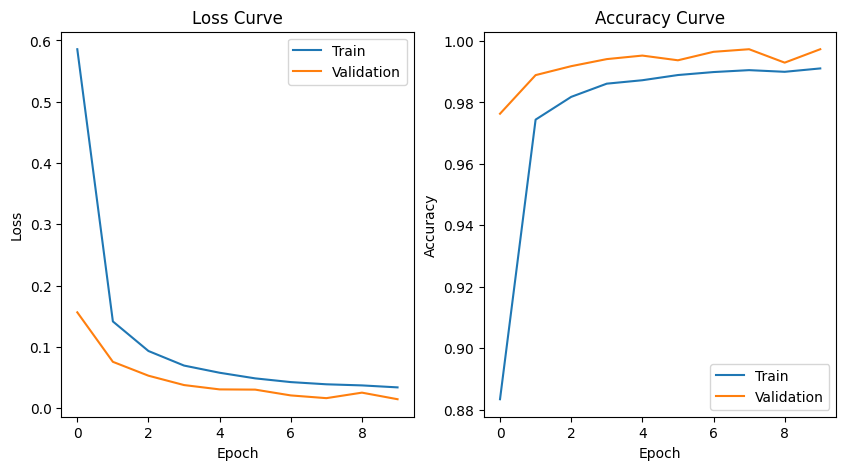

Test Loss: 0.0142, Test Acc: 0.9976

In [11]:
# Initialize the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_accuracy = correct_test / total_test
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

In [26]:
root_dir = '/kaggle/input/asl-alphabet-test'
test_data = datasets.ImageFolder(root=root_dir, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=32)

In [27]:
# Initialize empty lists to store test labels and predictions
test_labels = []
test_predictions = []

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        
        # Append test labels and predictions to the lists
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test / total_test
print("Final External Test Dataset Results: ")
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Convert lists to arrays
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

Final External Test Dataset Results:

Test Loss: 8.3776, Test Acc: 0.2929

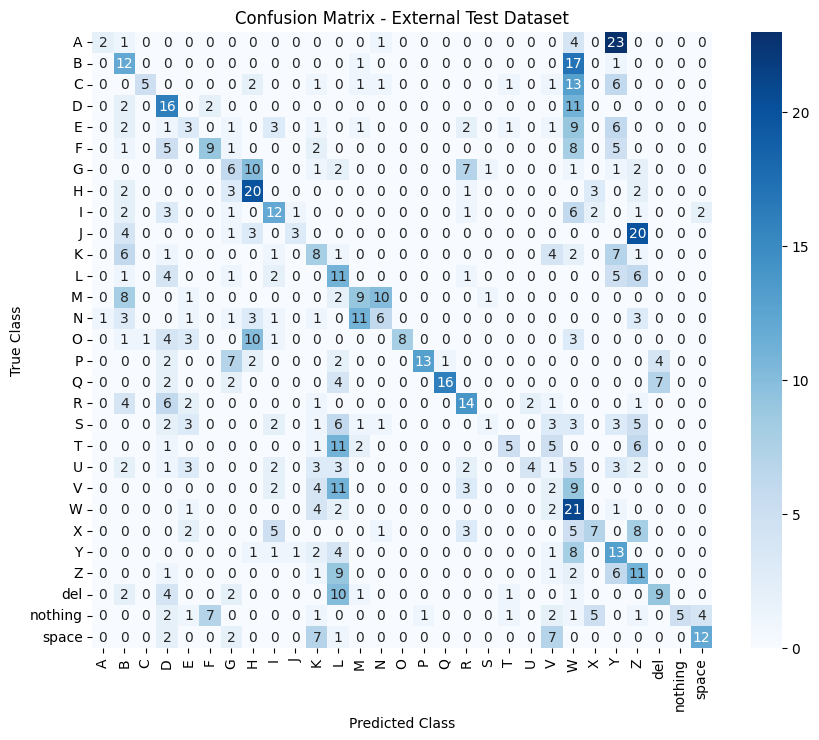

In [28]:
# Generate confusion matrix for the fine-tuned model
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix for the fine-tuned model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix - External Test Dataset")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()